A partir del dataset Multivariate_pollution.csv

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy import optimize
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def load_csv_dataset(dataset, modifyColumns, dropColumns):
    # Cargar el archivo CSV en un DataFrame de Pandas
    data = pd.read_csv(dataset, encoding='latin-1')

    # Modificar columnas según la lógica deseada
    columns = data.columns
    mappings = {}  # Diccionario para almacenar los mapeos

    for index in modifyColumns:
        name = columns[index]
        unique_values = list(data[name].unique())
        value_map = dict(zip(unique_values, [i for i in range(len(unique_values))]))
        data[name] = data[name].map(value_map)
        mappings[name] = value_map  # Almacenar el mapeo en el diccionario

    # Eliminar columnas no deseadas
    data = data.drop([columns[index] for index in dropColumns], axis=1)

    return data, mappings

data_pd, mappings = load_csv_dataset("/content/gdrive/MyDrive/IA2/pregunta2/LSTM-Multivariate_pollution.csv", [i for i in range(0,8) if i in []], [0,1,2,4,5,6,7,8])

# Imprimir el mapeo de nombres de datos categóricos a valores numéricos
for column, mapping in mappings.items():
    print(f"Columna: {column}")
    print("Mapeo:")
    for key, value in mapping.items():
        print(f"{key} -> {value}")
    print()



In [4]:
print(data_pd)#nos quedamos solo con la columna temp

       temp
0      -4.0
1      -4.0
2      -5.0
3      -5.0
4      -5.0
...     ...
43795  -2.0
43796  -3.0
43797  -3.0
43798  -4.0
43799  -3.0

[43800 rows x 1 columns]


In [5]:
def preprocess_dataset(data):
    # Realizar operaciones adicionales en Pandas(para datos nan)

    # columnas_especificas = ['bmi']
    # media_columnas = data[columnas_especificas].mean()
    # data[columnas_especificas] = data[columnas_especificas].fillna(media_columnas)


    return data.to_numpy()
data= preprocess_dataset(data_pd)

In [6]:
data.shape

(43800, 1)

In [7]:
print(data)

[[-4.]
 [-4.]
 [-5.]
 ...
 [-3.]
 [-4.]
 [-3.]]


In [8]:
# Normalización
data_min = np.min(data)
data_max = np.max(data)
print(data_min)
print(data_max)
data = 2 * ((data - data_min) / (data_max - data_min)) - 1


-19.0
42.0


In [9]:
def generate_time_series(data, n_steps, n_forecast=1):#se generara las series de tiempo
    X, y = [], []
    for i in range(len(data) - n_steps - n_forecast + 1):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps:i+n_steps+n_forecast])
    return np.array(X), np.array(y)

In [11]:
n_steps = 60  # 60 datos en cada serie temporal
n_forecast = 30  # predecir cuantos datos siguientes
X, y = generate_time_series(data, n_steps, n_forecast)

In [ ]:
print(y.shape)

(43711, 30, 1)


In [ ]:
# esta funcion genera series temporales sin taponerase unas a otras

# def generate_non_overlapping_series(data, n_steps, n_forecast=1):
#     X, y = [], []
#     for i in range(0, len(data) - n_steps - n_forecast + 1, n_steps):
#         X.append(data[i:i+n_steps])
#         y.append(data[i+n_steps:i+n_steps+n_forecast])
#     return np.array(X), np.array(y)

In [ ]:
# n_steps = 60
# n_forecast = 10
# X, y = generate_non_overlapping_series(data, n_steps, n_forecast)

In [12]:
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)


In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

In [14]:

train_size = int(0.7 * len(X))#70 % para entrenamietno
valid_size = int(0.2 * len(X))#20% para validacion, 10% restante para evaluacion

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test = X[train_size+valid_size:], y[train_size+valid_size:]

# Remodelación para garantizar que y tenga solo dos dimensiones
y_train = y_train.reshape(y_train.shape[0], -1)  # esto aplanaría la segunda dimensión
y_valid = y_valid.reshape(y_valid.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

print(X_train.shape, y_train.shape)

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}


(30597, 60, 1) (30597, 30)


In [ ]:
# # 7009
# n_steps = 30
# X_train, y_train = X[:400, :n_steps], y[:400, -30:, 0]
# X_valid, y_valid = X[400:600, :n_steps], y[400:600, -30:, 0]
# X_test, y_test = X[600:, :n_steps], y[600:, -30:, 0]

# print(X_train.shape, y_train.shape)

# dataset = {
#     'train': TimeSeriesDataset(X_train, y_train),
#     'eval': TimeSeriesDataset(X_valid, y_valid),
#     'test': TimeSeriesDataset(X_test, y_test, train=False)
# }

# dataloader = {
#     'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
#     'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
#     'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
# }

In [ ]:
X_test.shape, y_test.shape

((4372, 60, 1), (4372, 30))

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$", num_obs=60):
    r, c = 3, 3
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))

    # Generar un orden aleatorio para los ejemplos de entrenamiento
    num_examples = series.shape[0]
    random_order = np.random.permutation(num_examples)

    for row in range(r):
        for col in range(c):
            plt.sca(axes[row][col])
            ix = random_order[col + row*c]
            # Mostrar solo las últimas 'num_obs' observaciones
            last_obs = -num_obs if num_obs > 0 else None
            plt.plot(series[ix, last_obs:], ".-")
            if y is not None:
                plt.plot(range(len(series[ix, last_obs:]), len(series[ix, last_obs:])+len(y[ix])), y[ix], "bx", markersize=10)
            if y_pred is not None:
                plt.plot(range(len(series[ix, last_obs:]), len(series[ix, last_obs:])+len(y_pred[ix])), y_pred[ix], "ro")
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, last_obs:]), len(series[ix, last_obs:])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, last_obs:]), len(series[ix, last_obs:])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            plt.grid(True)
            plt.hlines(0, 0, num_obs, linewidth=1)
            #plt.axis([0, num_obs + len(y[ix]), -1, 1])
            if x_label and row == r - 1:
                plt.xlabel(x_label, fontsize=16)
            if y_label and col == 0:
                plt.ylabel(y_label, fontsize=16, rotation=0)

    plt.show()

#plot_series(X_train, y_train)

In [ ]:


class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    x = self.fc(x[:,-1])
    return x



In [16]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10, lr=1e-3, save_path='./model_checkpoint.pth'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

        # Guardar los parámetros del modelo después de cada época
        torch.save(model.state_dict(), f"{save_path}_epoch_{epoch}.pth")

In [17]:
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [ ]:
rnn = DeepRNN(n_out=30)
fit(rnn, dataloader)

loss 0.00977 val_loss 0.01031: 100%|██████████| 10/10 [01:38<00:00,  9.86s/it]


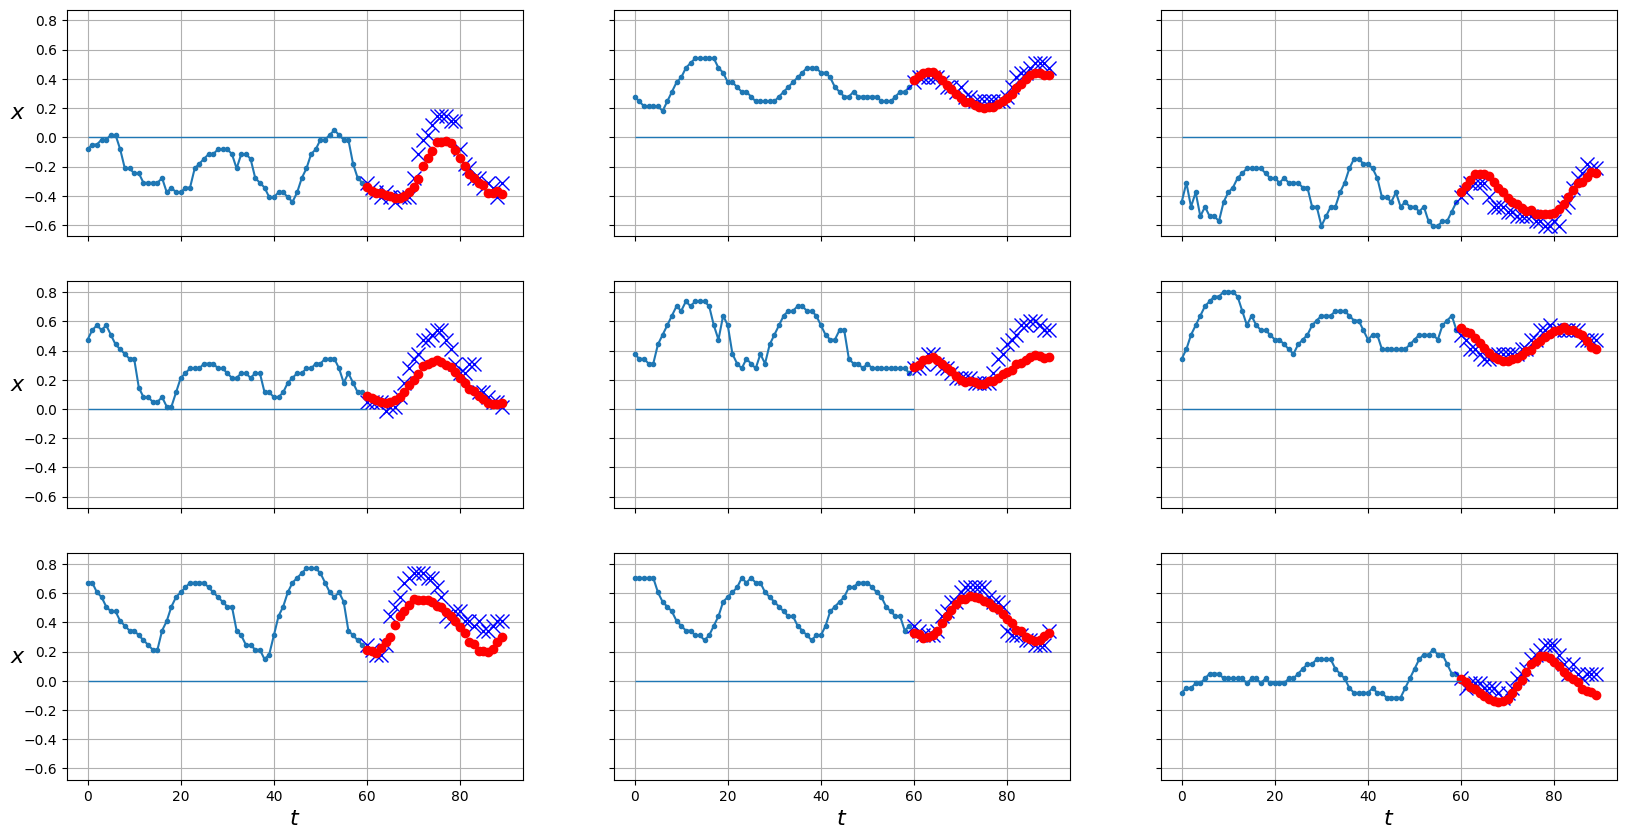

0.008831441

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

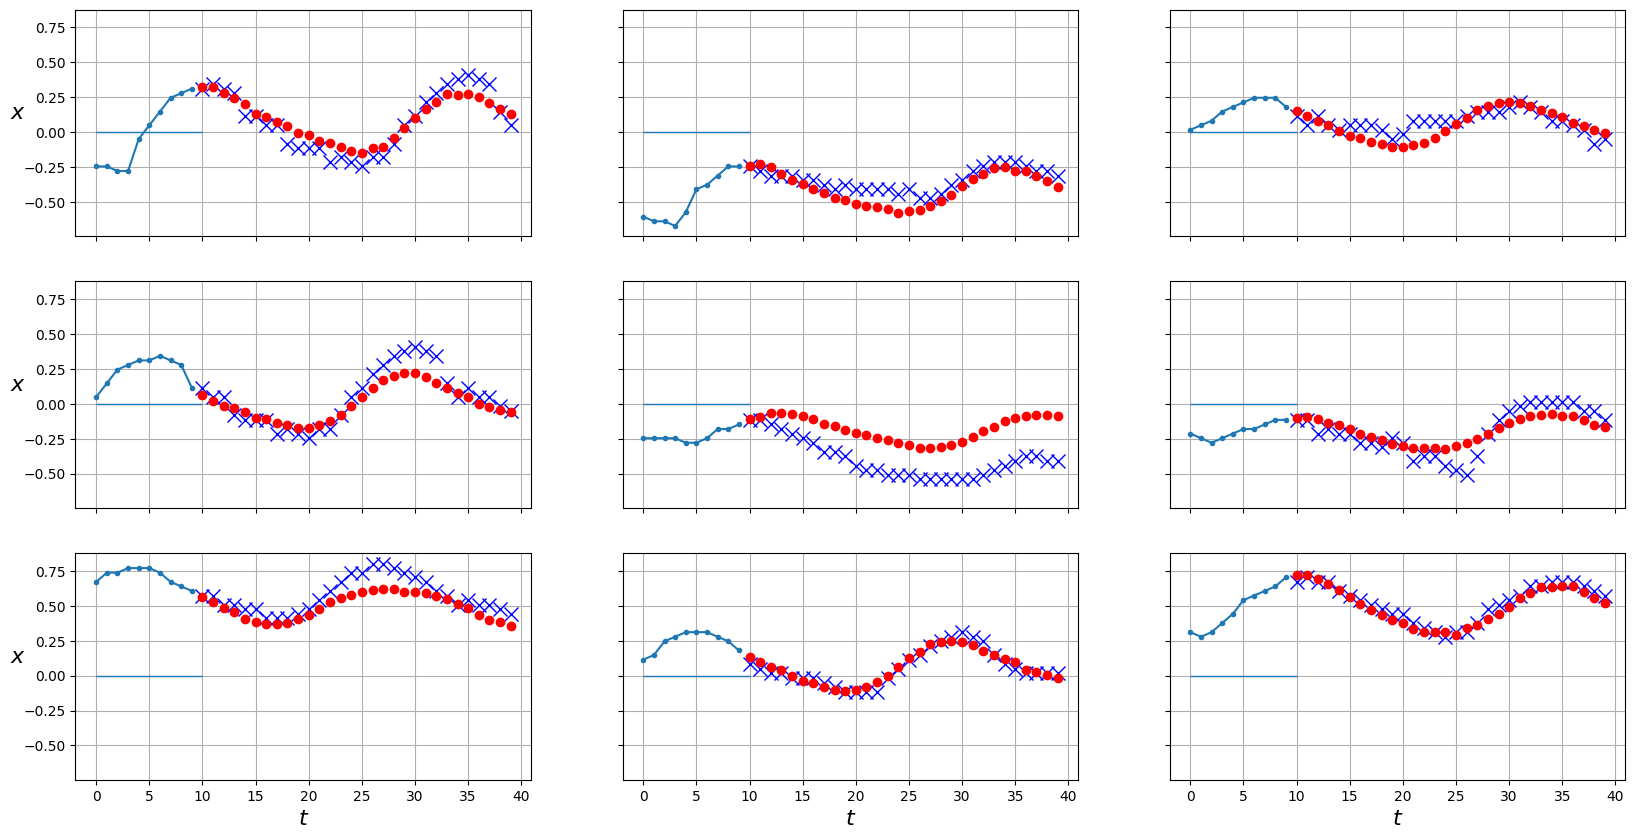

0.008831441

In [ ]:
# predecimos los valores de la serie de tiempo
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy(), num_obs=10)
mean_squared_error(y_test, y_pred.cpu())

In [ ]:
rnn2 = DeepRNN(n_out=30)
fit(rnn2, dataloader,lr=2e-3)

loss 0.00980 val_loss 0.01002: 100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


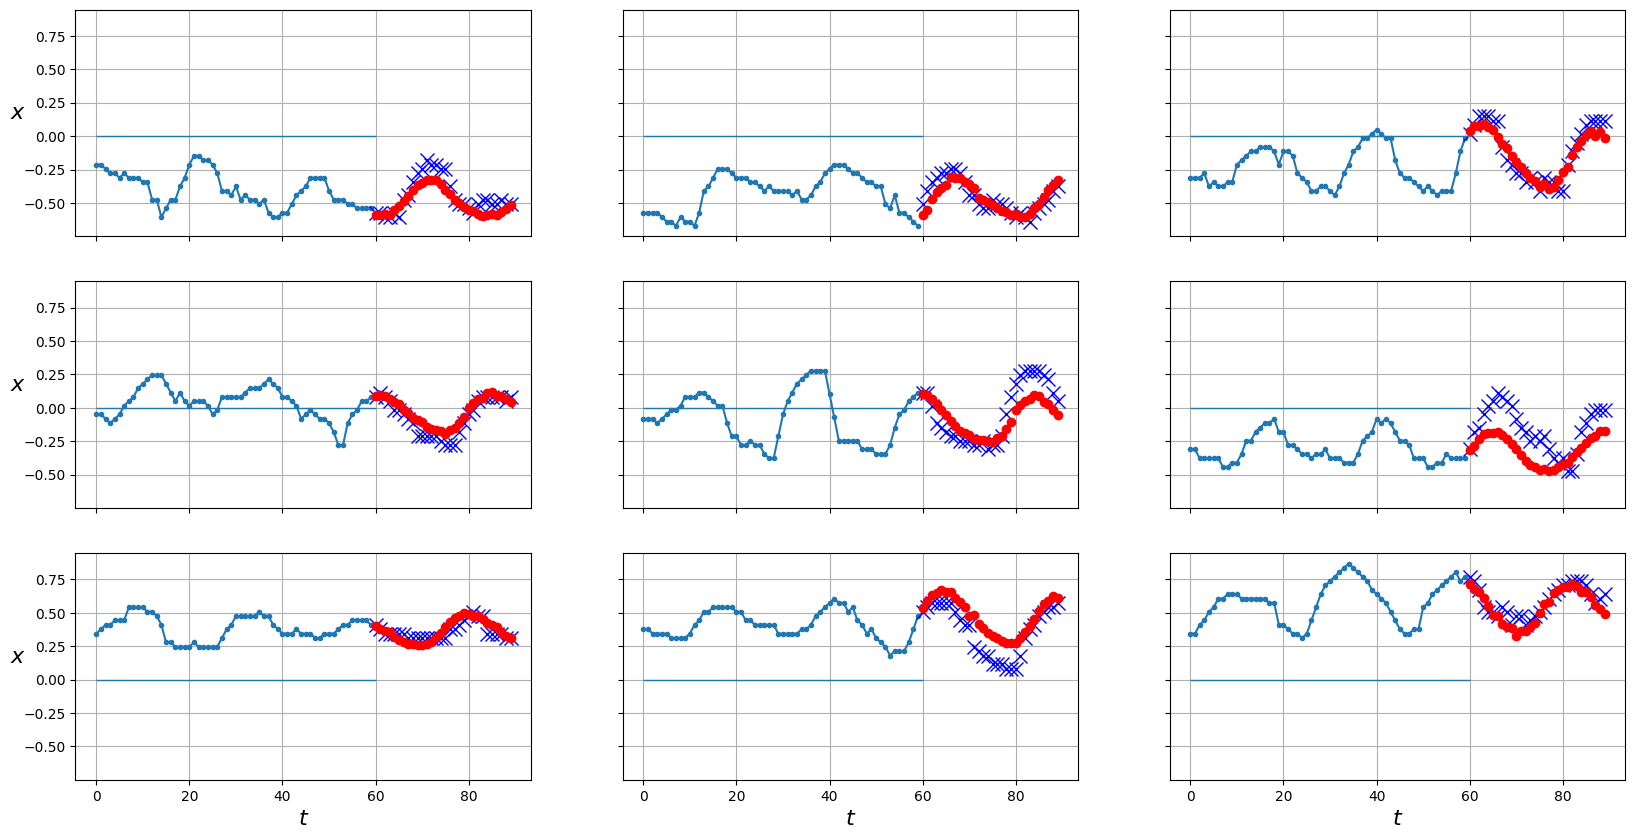

0.008509059

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.GRU(input_size=1, hidden_size=60, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(60, n_out)

  def forward(self, x):
    x, h = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

In [ ]:

# instanciamos el modelo y lo entrenamlll;;....................jjj...iiiiiiii...
rnn3 = DeepRNN(n_out=30)
fit(rnn3, dataloader, epochs=40)




loss 0.00666 val_loss 0.00986: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


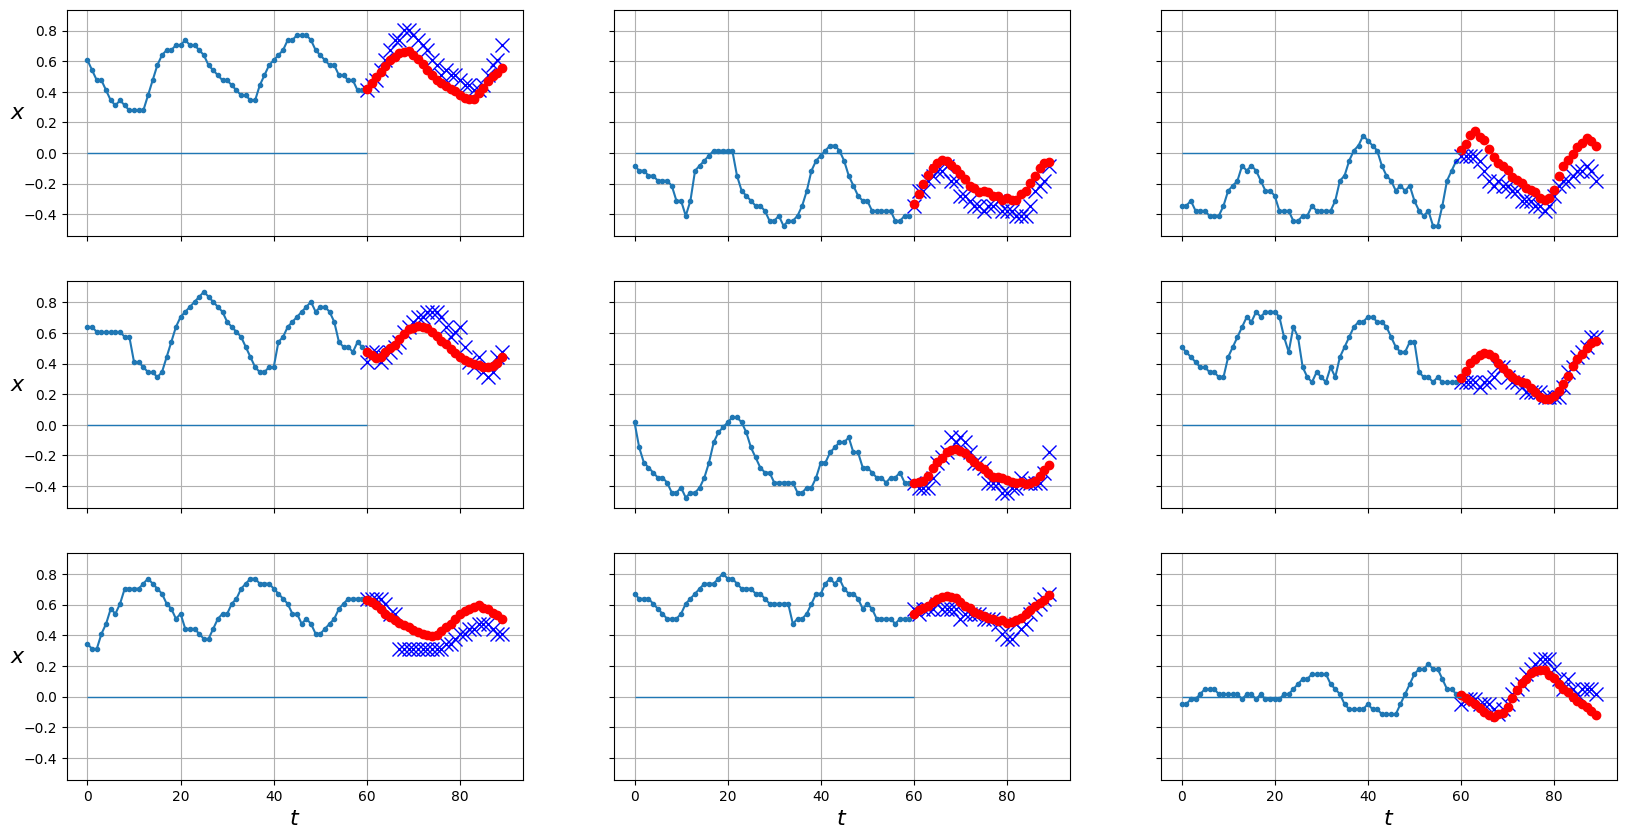

0.008025203

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn3, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

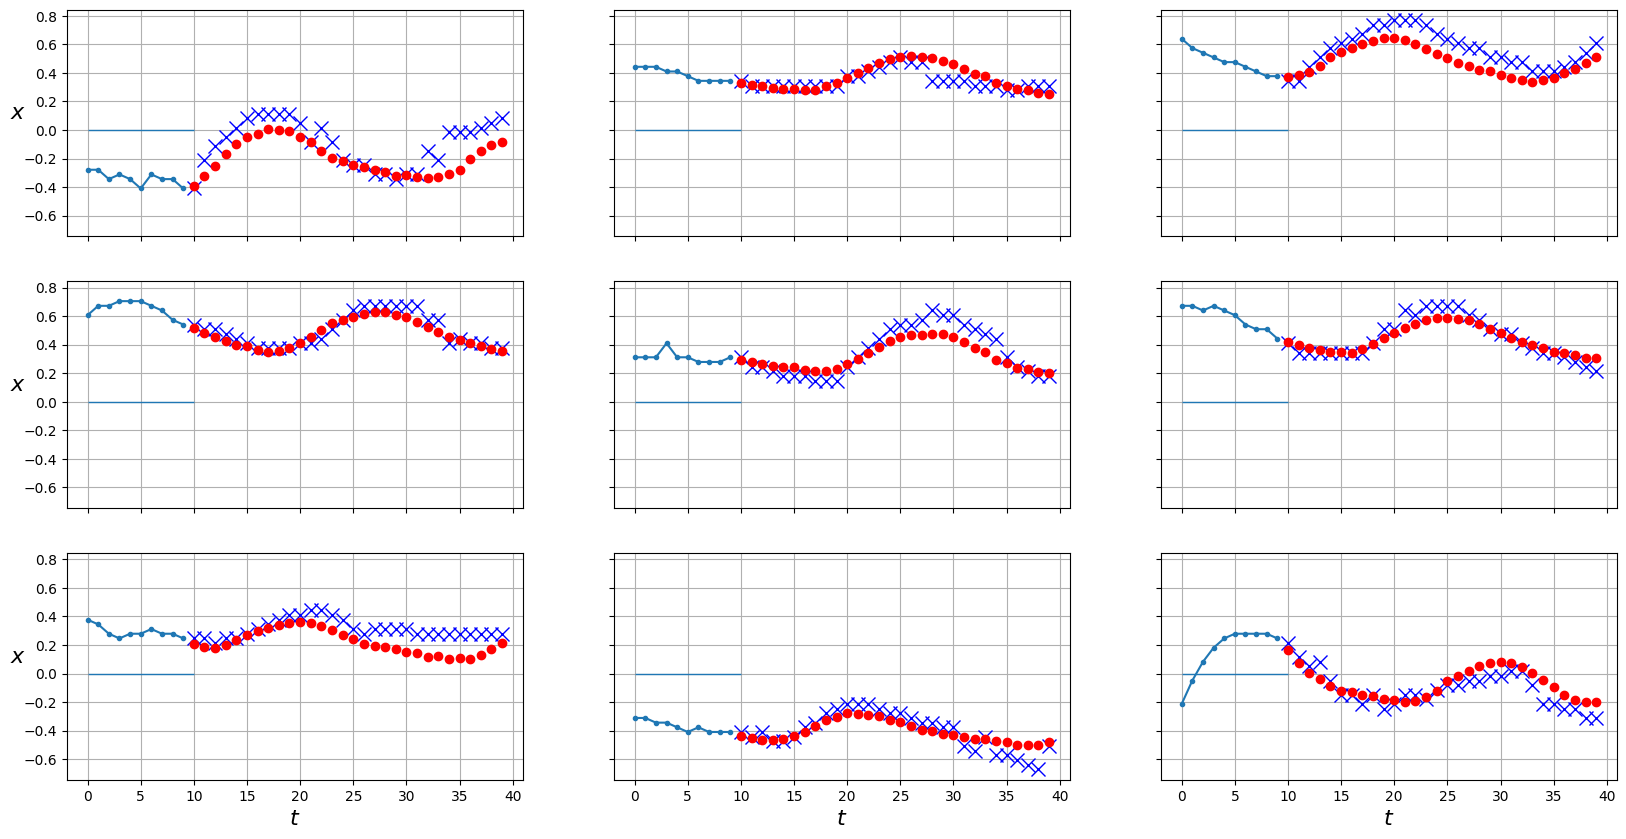

0.008025203

In [ ]:
# predecimos los valores de la serie de tiempo
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn3, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy(), num_obs=10)
mean_squared_error(y_test, y_pred.cpu())

In [ ]:
# Asegúrate de que la definición de tu modelo (DeepRNN) está presente en tu script o notebook
model = DeepRNN(n_out=30)  # Inicializa un nuevo modelo

# Carga el estado del modelo
model_path = '/content/model_checkpoint.pth_epoch_40.pth'  # Reemplaza con la ruta a tu archivo de modelo
model_state_dict = torch.load(model_path)

# Aplica el estado al modelo
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
data_min = np.min(data)
data_max = np.max(data)
print(data_min)
print(data_max)

-1.0
1.0


In [ ]:
import numpy as np
import torch

def normalize(data, data_min=-1, data_max=1):
    """
    Normalizes the input data using the provided min and max values.

    Parameters:
    - data: List or numpy array of data points.
    - data_min: Minimum value of the data.
    - data_max: Maximum value of the data.

    Returns:
    - Normalized data.
    """
    return 2 * ((np.array(data) - data_min) / (data_max - data_min)) - 1

def predict_temperature(model, past_days, data_min=-1, data_max=1, device="cuda"):
    """
    Predicts the temperature for the next day using a sequence of past days.

    Parameters:
    - model: The trained RNN model.
    - past_days: A sequence of temperatures from past days, should have the length required by the model (n_steps).
    - data_min: The minimum value of the original temperature data.
    - data_max: The maximum value of the original temperature data.
    - device: Device to which the model and data are sent.

    Returns:
    - A desnormalized prediction for the temperature of the next day.
    """

    # Normalize past_days
    past_days_normalized = normalize(past_days, data_min, data_max)

    # Convert past_days_normalized to a PyTorch tensor with the correct shape
    input_data = torch.tensor(past_days_normalized, dtype=torch.float32).view(1, -1, 1).to(device)

    # Ensure the model is in evaluation mode and send to the desired device
    model.eval().to(device)

    # Get the prediction from the model
    with torch.no_grad():
        prediction = model(input_data)

    # Desnormalize the prediction
    normalized_value = prediction[0, 0].item()
    desnormalized_prediction = (normalized_value + 1) * 0.5 * (data_max - data_min) + data_min

    return desnormalized_prediction

# Ejemplo de uso:
# Suponiendo que `model` es tu modelo entrenado y tienes los valores mínimo y máximo de tus datos originales.
past_data = [0.6, -0.4, 0.1, 0.5, -0.4, 0.0, 0.1, 0.5, 0.8, 0.5]
predicted_temp = predict_temperature(model, past_data, data_min, data_max)
print(f"The predicted temperature for the next day is: {predicted_temp:.2f}°C")

The predicted temperature for the next day is: 0.37°C


In [18]:
class DeepRNN(torch.nn.Module):
    def __init__(self, n_out=10):
        super(DeepRNN, self).__init__()
        self.rnn = torch.nn.GRU(input_size=1, hidden_size=120, num_layers=3, batch_first=True, dropout=0.2)
        self.fc1 = torch.nn.Linear(120, 80)
        self.dropout = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(80, 40)
        self.fc_out = torch.nn.Linear(40, n_out)

    def forward(self, x):
        x, h = self.rnn(x)
        x = self.fc1(x[:, -1])
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc_out(x)
        return x

In [19]:

# instanciamos el modelo y lo entrenamlll;;....................jjj...iiiiiiii...
rnn3 = DeepRNN(n_out=30)
fit(rnn3, dataloader, epochs=40)


loss 0.00266 val_loss 0.01262: 100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


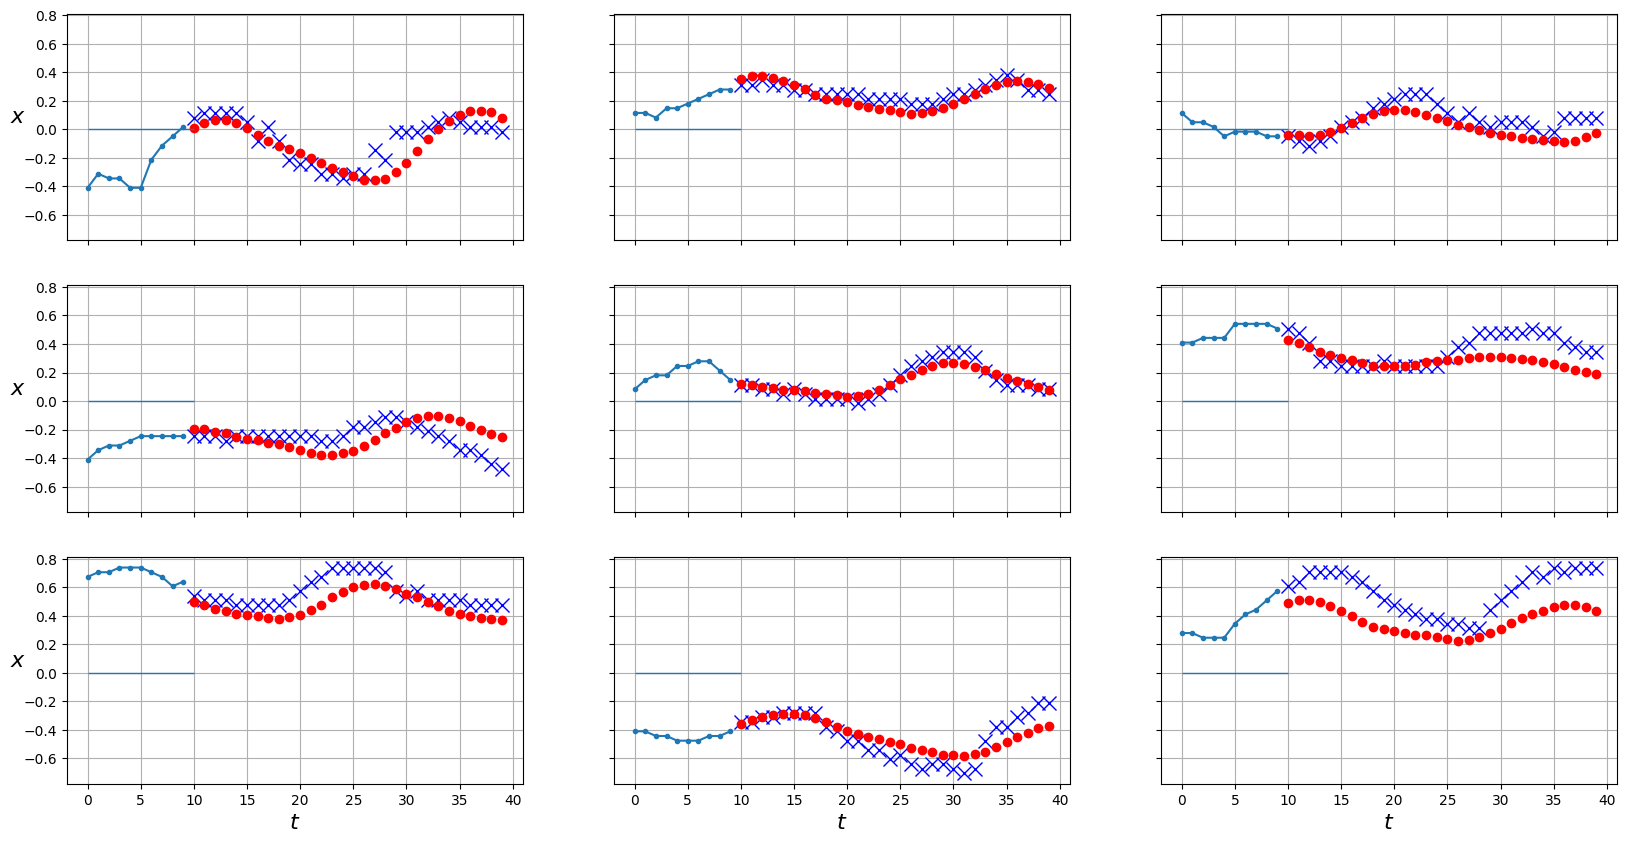

0.012068049

In [20]:
# predecimos los valores de la serie de tiempo
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn3, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy(), num_obs=10)
mean_squared_error(y_test, y_pred.cpu())

In [22]:
class DeepLSTM(torch.nn.Module):
    def __init__(self, n_out=10):
        super().__init__()
        self.rnn = torch.nn.LSTM(input_size=1, hidden_size=60, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(60, n_out)

    def forward(self, x):
        x, (h, c) = self.rnn(x)  # LSTM devuelve tanto el estado oculto (h) como el estado de la celda (c)
        x = self.fc(x[:, -1])
        return x

In [23]:
# instanciamos el modelo y lo entrenamlll;;....................jjj...iiiiiiii...
rnn4 = DeepLSTM(n_out=30)
fit(rnn4, dataloader, epochs=40)

loss 0.00743 val_loss 0.00900: 100%|██████████| 40/40 [00:57<00:00,  1.43s/it]


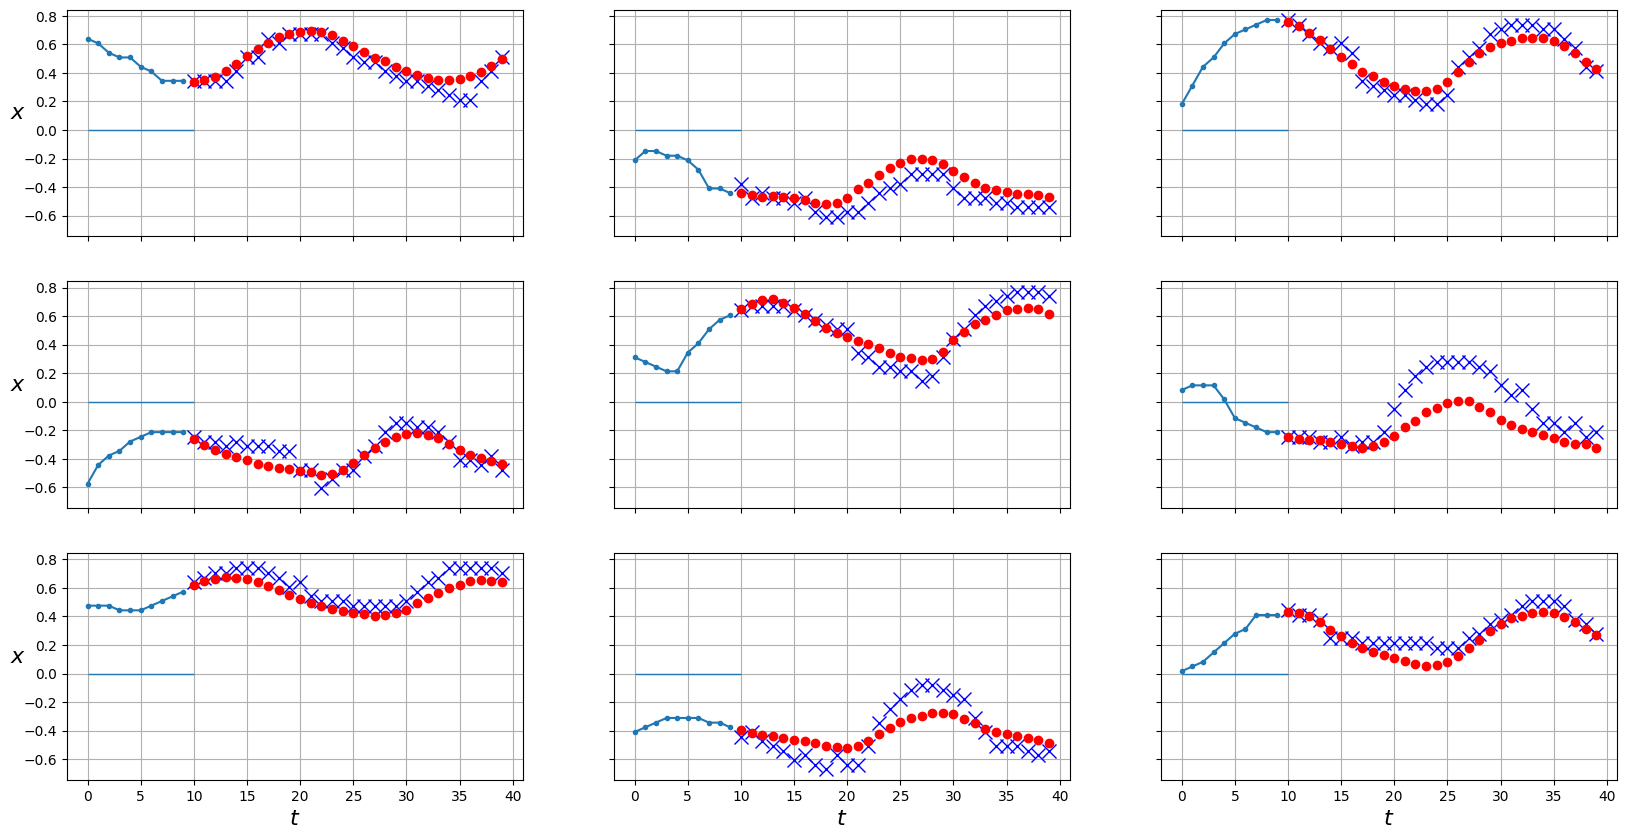

0.0075243516

In [24]:
# predecimos los valores de la serie de tiempo
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn4, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy(), num_obs=10)
mean_squared_error(y_test, y_pred.cpu())

In [25]:
n_steps = 120
n_forecast = 30  # predecir cuantos datos siguientes
X, y = generate_time_series(data, n_steps, n_forecast)

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)


train_size = int(0.7 * len(X))#70 % para entrenamietno
valid_size = int(0.2 * len(X))#20% para validacion, 10% restante para evaluacion

X_train, y_train = X[:train_size], y[:train_size]
X_valid, y_valid = X[train_size:train_size+valid_size], y[train_size:train_size+valid_size]
X_test, y_test = X[train_size+valid_size:], y[train_size+valid_size:]

# Remodelación para garantizar que y tenga solo dos dimensiones
y_train = y_train.reshape(y_train.shape[0], -1)  # esto aplanaría la segunda dimensión
y_valid = y_valid.reshape(y_valid.shape[0], -1)
y_test = y_test.reshape(y_test.shape[0], -1)

print(X_train.shape, y_train.shape)

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader2 = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}



(30555, 120, 1) (30555, 30)


In [26]:
# instanciamos el modelo y lo entrenamlll;;....................jjj...iiiiiiii...
rnn4 = DeepLSTM(n_out=30)
fit(rnn4, dataloader2, epochs=40)

loss 0.00720 val_loss 0.00929: 100%|██████████| 40/40 [01:07<00:00,  1.68s/it]


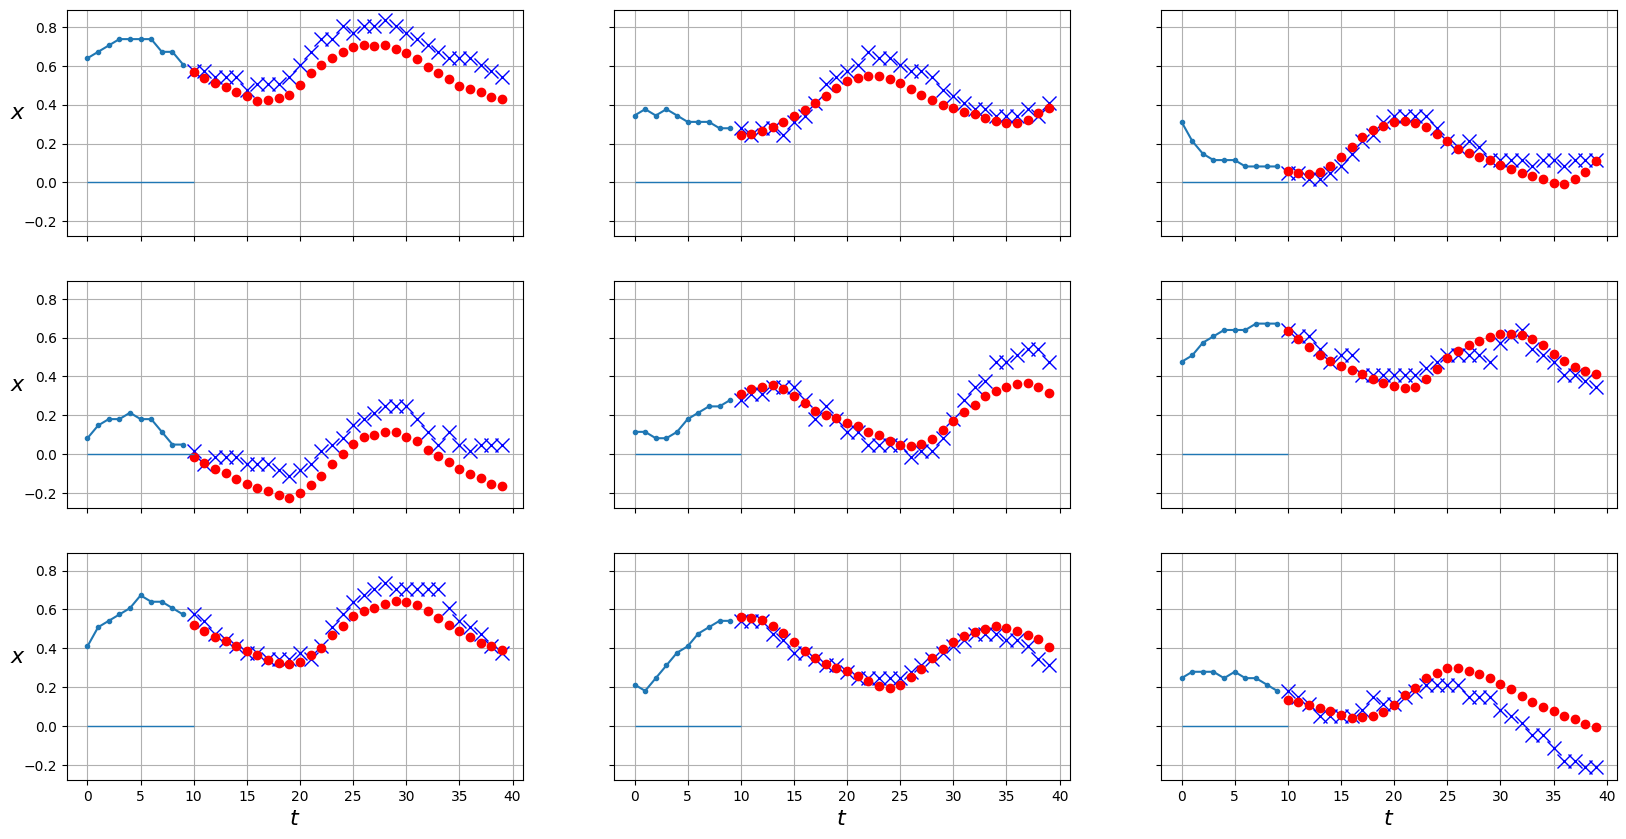

0.007383338

In [28]:
# predecimos los valores de la serie de tiempo
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn4, dataloader2['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy(), num_obs=10)
mean_squared_error(y_test, y_pred.cpu())

In [32]:
import torch.nn as nn

class DeepLSTM2(nn.Module):
    def __init__(self, n_out=10):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, num_layers=1, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1, batch_first=True, dropout=0.2)

        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, n_out)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout(x)

        x, _ = self.lstm2(x)
        x = self.dropout(x)

        x, _ = self.lstm3(x)
        x = x[:, -1, :]  # seleccionamos solo la última secuencia

        x = self.fc1(x)
        x = self.dropout(x)

        x = self.fc2(x)

        return x


In [33]:
# instanciamos el modelo y lo entrenamlll;;....................jjj...iiiiiiii...

rnn5 = DeepLSTM2(n_out=30)
fit(rnn5, dataloader2, epochs=40)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
loss 0.01076 val_loss 0.00910: 100%|██████████| 40/40 [02:02<00:00,  3.05s/it]


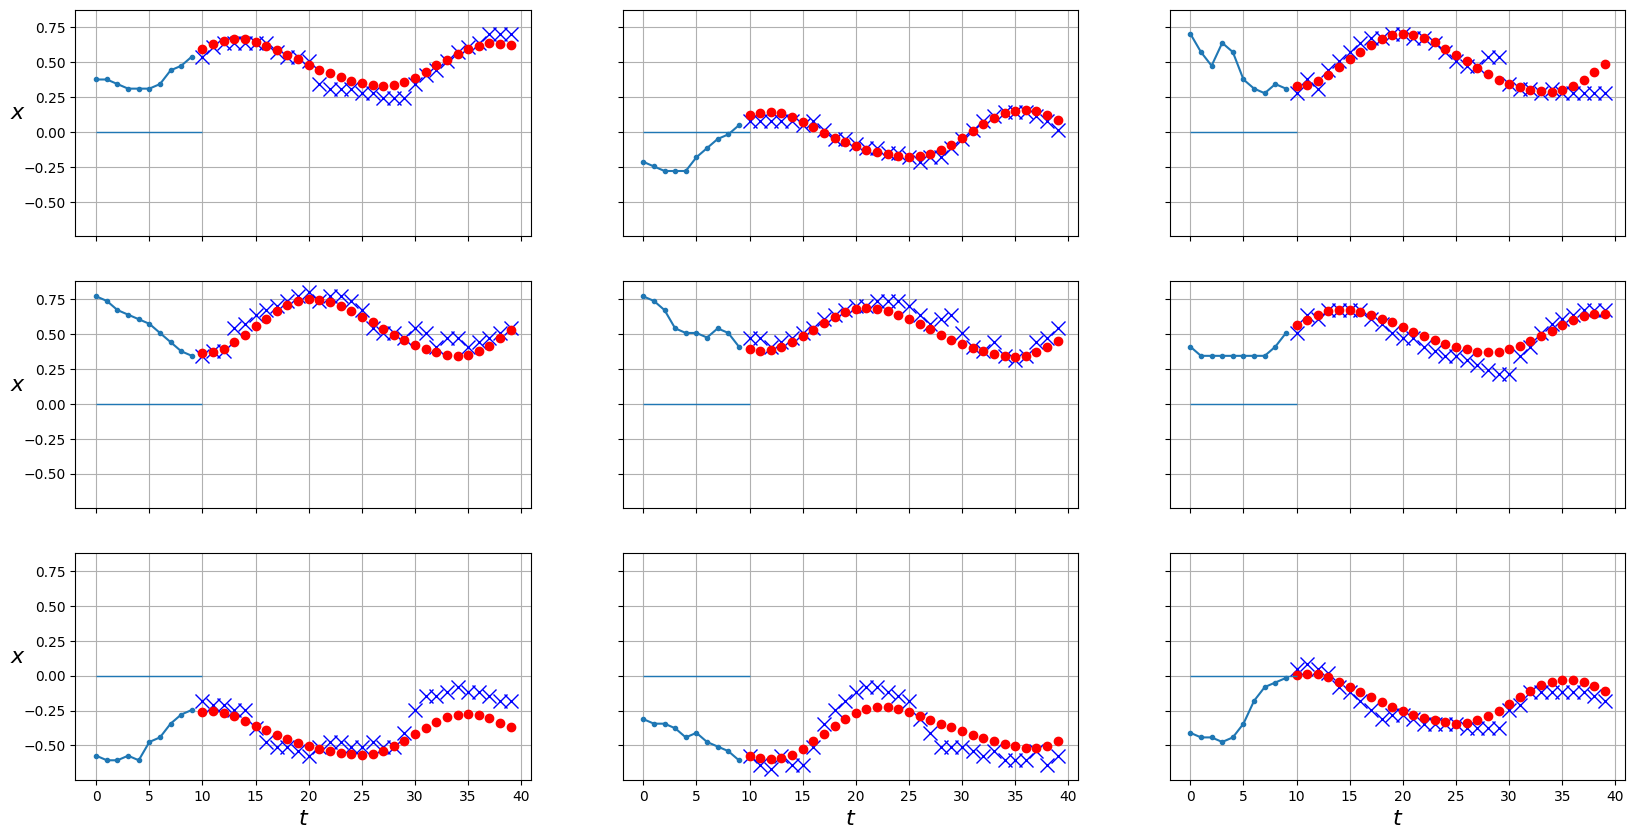

0.008207216

In [34]:
# predecimos los valores de la serie de tiempo
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn5, dataloader2['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy(), num_obs=10)
mean_squared_error(y_test, y_pred.cpu())

In [43]:
import numpy as np

def generate_spring_temperatures(days=90, measurements_per_day=4):
    t = np.linspace(0, days, days * measurements_per_day)
    daily_variation = 7 * np.sin(np.pi * t / 2)  # 7 grados de variación diaria
    base_temp = 17.5  # Media entre 10 y 25
    noise = np.random.normal(0, 2, len(t))  # Ruido con desviación estándar de 2°C
    temperatures = base_temp + daily_variation + noise

    # Redondear y convertir a enteros
    return np.round(temperatures).astype(int)




In [44]:
def generate_summer_temperatures(days=90, measurements_per_day=4):
    t = np.linspace(0, days, days * measurements_per_day)
    daily_variation = 7 * np.sin(np.pi * t / 2)  # 7 grados de variación diaria
    base_temp = 27.5  # Media entre 20 y 35
    noise = np.random.normal(0, 3, len(t))  # Ruido con desviación estándar de 3°C
    temperatures = base_temp + daily_variation + noise

    # Redondear y convertir a enteros
    return np.round(temperatures).astype(int)



In [45]:
def generate_fall_temperatures(days=90, measurements_per_day=4):
    t = np.linspace(0, days, days * measurements_per_day)
    daily_variation = 5 * np.sin(np.pi * t / 2)  # 5 grados de variación diaria
    base_temp = 15  # Media entre 10 y 20
    noise = np.random.normal(0, 2, len(t))  # Ruido con desviación estándar de 2°C
    temperatures = base_temp + daily_variation + noise

    # Redondear y convertir a enteros
    return np.round(temperatures).astype(int)



In [46]:
def generate_winter_temperatures(days=90, measurements_per_day=4):
    t = np.linspace(0, days, days * measurements_per_day)
    daily_variation = 4 * np.sin(np.pi * t / 2)  # 4 grados de variación diaria
    base_temp = 5  # Media entre 0 y 10
    noise = np.random.normal(0, 1.5, len(t))  # Ruido con desviación estándar de 1.5°C
    temperatures = base_temp + daily_variation + noise

    # Redondear y convertir a enteros
    return np.round(temperatures).astype(int)



In [47]:
spring_temps = generate_spring_temperatures()
summer_temps = generate_summer_temperatures()
fall_temps = generate_fall_temperatures()
winter_temps = generate_winter_temperatures()


In [48]:
yearly_temps = np.concatenate([spring_temps, summer_temps, fall_temps, winter_temps])

In [49]:
print(yearly_temps)#nos quedamos solo con la columna temp

[16 20 21 ...  7  5  1]


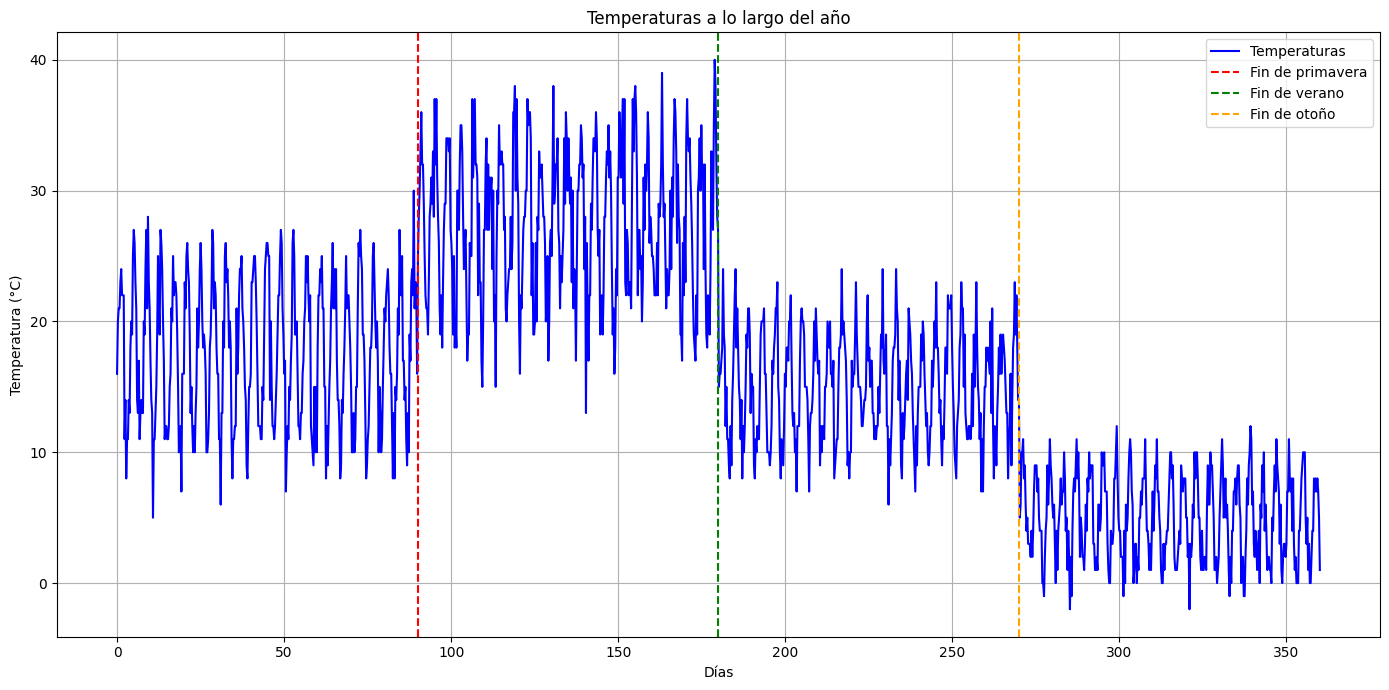

In [52]:
# # Trunca el eje x para que tenga la misma longitud que `yearly_temps`
# time = time[:len(yearly_temps)]

# # Ahora, utiliza el mismo código de visualización que proporcioné anteriormente:
# plt.figure(figsize=(14, 7))
# plt.plot(time, yearly_temps, label='Temperaturas', color='blue')

# # Define los límites de las estaciones (para añadir líneas verticales)
# spring_end = len(spring_temps)
# summer_end = spring_end + len(summer_temps)
# fall_end = summer_end + len(fall_temps)

# plt.axvline(spring_end/4, color='red', linestyle='--', label='Fin de primavera')
# plt.axvline(summer_end/4, color='green', linestyle='--', label='Fin de verano')
# plt.axvline(fall_end/4, color='orange', linestyle='--', label='Fin de otoño')

# # Añadir título y etiquetas
# plt.title("Temperaturas a lo largo del año")
# plt.xlabel("Días")
# plt.ylabel("Temperatura (°C)")
# plt.legend()

# # Mostrar la gráfica
# plt.grid(True)
# plt.tight_layout()
# plt.show()
